# Malaria Cell Detection with RAG + CoT + PPO

---------------------

## Setup and Imports

In [1]:
!pip install -q faiss-cpu 
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from typing import List, Dict, Tuple, Optional, Union, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torchvision import transforms
import timm
from timm.models.vision_transformer import VisionTransformer

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import faiss
import cv2
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Limit GPU memory usage
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 62.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-04-20 18:38:33.754445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745174313.931629      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745174313.984604      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


## Dataset and Data Processing

In [2]:
class MalariaDataset(Dataset):
    def __init__(self, df, transform=None, return_path=False):
        self.df = df
        self.transform = transform
        self.return_path = return_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']
        
        # Read image
        img = np.array(Image.open(img_path).convert('RGB'))
        
        # Apply transformations
        if self.transform:
            img = self.transform(image=img)['image']
        
        if self.return_path:
            return img, label, img_path
        return img, label

def create_dataframe(data_dir):
    valid_extensions = ('.png', '.jpg', '.jpeg')
    parasitized_dir = os.path.join(data_dir, 'Parasitized')
    uninfected_dir = os.path.join(data_dir, 'Uninfected')
    
    # Include full paths for parasitized files
    parasitized_files = [os.path.join(parasitized_dir, f) 
                     for f in os.listdir(parasitized_dir) 
                     if f.lower().endswith(valid_extensions) and os.path.isfile(os.path.join(parasitized_dir, f))]
    
    # Include full paths for uninfected files
    uninfected_files = [os.path.join(uninfected_dir, f) 
                        for f in os.listdir(uninfected_dir) 
                        if f.lower().endswith(valid_extensions)]
    
    files = parasitized_files + uninfected_files
    labels = [1] * len(parasitized_files) + [0] * len(uninfected_files)
    
    df = pd.DataFrame({
        'image_path': files,
        'label': labels
    })
    
    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df

def get_transforms(img_size=224):
    train_transforms = A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transforms = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    return train_transforms, val_transforms

def train_val_test_split(df, train_size=0.7, val_size=0.15, test_size=0.15):
    train_df = df.sample(frac=train_size, random_state=42)
    remaining_df = df.drop(train_df.index)
    
    # Calculate the proportion for validation from the remaining data
    val_proportion = val_size / (val_size + test_size)
    val_df = remaining_df.sample(frac=val_proportion, random_state=42)
    test_df = remaining_df.drop(val_df.index)
    
    return train_df, val_df, test_df

## Retrieval-Augmented Generation (RAG)

In [3]:
class MalariaImageEmbedder:
    """Extract embeddings from malaria cell images for RAG."""
    def __init__(self, model_name='resnet50', embedding_dim=2048):
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.model.eval()
        self.model = self.model.to(device)
        self.transforms = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        self.embedding_dim = embedding_dim
    
    def get_embedding(self, image_path):
        """Extract embedding from a single image."""
        img = np.array(Image.open(image_path).convert('RGB'))
        img = self.transforms(image=img)['image']
        img = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            embedding = self.model(img)
        
        return embedding.cpu().numpy().flatten()
    
    def get_batch_embeddings(self, image_paths, batch_size=32):
        """Extract embeddings for a batch of images."""
        embeddings = []
        
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_imgs = []
            
            for path in batch_paths:
                img = np.array(Image.open(path).convert('RGB'))
                img = self.transforms(image=img)['image']
                batch_imgs.append(img)
            
            batch_tensor = torch.stack(batch_imgs).to(device)
            
            with torch.no_grad():
                batch_embeddings = self.model(batch_tensor)
            
            embeddings.extend(batch_embeddings.cpu().numpy())
        
        return np.array(embeddings)

class MalariaKnowledgeBase:
    """Knowledge base for retrieving similar malaria cell images."""
    def __init__(self, embedder, index_type='L2'):
        self.embedder = embedder
        self.embedding_dim = embedder.embedding_dim
        self.index = faiss.IndexFlatL2(self.embedding_dim)
        self.image_paths = []
        self.labels = []
        
    def add_images(self, df):
        """Add images from DataFrame to the knowledge base."""
        embeddings = self.embedder.get_batch_embeddings(df['image_path'].tolist())
        self.index.add(embeddings)
        self.image_paths.extend(df['image_path'].tolist())
        self.labels.extend(df['label'].tolist())
        
    def retrieve_similar(self, query_image_path, k=5):
        """Retrieve k most similar images to the query image."""
        query_embedding = self.embedder.get_embedding(query_image_path)
        query_embedding = query_embedding.reshape(1, -1)
        
        distances, indices = self.index.search(query_embedding, k)
        
        similar_images = []
        for i, idx in enumerate(indices[0]):
            similar_images.append({
                'image_path': self.image_paths[idx],
                'label': self.labels[idx],
                'distance': distances[0][i]
            })
        
        return similar_images
    
    def retrieve_by_pathology(self, query_image_path, target_label, k=5):
        """Retrieve k most similar images with a specific pathology label."""
        similar_images = self.retrieve_similar(query_image_path, k=len(self.image_paths))
        filtered_images = [img for img in similar_images if img['label'] == target_label]
        return filtered_images[:k]

## Chain-of-Thought (CoT) Components

In [4]:
class MultiHeadLocalAttention(nn.Module):
    """Multi-head attention that attends to local image regions for explanation."""
    def __init__(self, dim, num_heads=8, head_dim=64, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.scale = head_dim ** -0.5
        
        inner_dim = head_dim * num_heads
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add singleton sequence dimension if needed
        b, n, c = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, self.num_heads, self.head_dim).transpose(1, 2), qkv)
        
        # Compute attention scores
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(dots, dim=-1)
        
        # Apply attention to values
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(b, n, self.num_heads * self.head_dim)
        out = self.to_out(out)
        
        return out, attn

class CoTReasoningBlock(nn.Module):
    """Chain-of-Thought reasoning block for step-by-step analysis."""
    def __init__(self, dim, num_heads=8, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadLocalAttention(dim, num_heads=num_heads, dropout=dropout)
        
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
        # Reasoning components
        self.reasoning_proj = nn.Linear(dim, dim)
        self.reasoning_gate = nn.Sequential(
            nn.Linear(dim, dim // 4),
            nn.ReLU(),
            nn.Linear(dim // 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, prev_reasoning=None):
        # Self-attention with reasoning
        h = self.norm1(x)
        h, attn_weights = self.attn(h)
        
        # Apply reasoning connection if available
        if prev_reasoning is not None:
            reasoning_weights = self.reasoning_gate(h)
            reasoning_features = self.reasoning_proj(prev_reasoning)
            h = h + reasoning_weights * reasoning_features
            
        x = x + h
        
        # MLP
        h = self.norm2(x)
        h = self.mlp(h)
        x = x + h
        
        return x, attn_weights

class PathologyFeatureExtractor(nn.Module):
    """Extract important pathology features from the image."""
    def __init__(self, in_channels=3, base_width=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, base_width, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_width)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Specific pathology feature detectors
        self.parasite_detector = nn.Sequential(
            nn.Conv2d(base_width, base_width*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_width*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_width*2, base_width*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_width*2),
            nn.ReLU(inplace=True)
        )
        
        self.cell_morphology_detector = nn.Sequential(
            nn.Conv2d(base_width, base_width*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_width*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_width*2, base_width*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_width*2),
            nn.ReLU(inplace=True)
        )
        
        # Feature attention gates
        self.parasite_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(base_width*2, base_width*2, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.cell_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(base_width*2, base_width*2, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Extract base features
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        base_features = self.maxpool(x)
        
        # Extract specialized pathology features
        parasite_features = self.parasite_detector(base_features)
        cell_features = self.cell_morphology_detector(base_features)
        
        # Apply attention
        parasite_attn = self.parasite_attn(parasite_features)
        cell_attn = self.cell_attn(cell_features)
        
        # Apply attention gates to features
        attended_parasite = parasite_features * parasite_attn
        attended_cell = cell_features * cell_attn
        
        # Save attention maps for visualization
        self.parasite_attention_map = parasite_attn
        self.cell_attention_map = cell_attn
        
        return attended_parasite, attended_cell

class CoTMalariaClassifier(nn.Module):
    """Malaria classifier with Chain-of-Thought reasoning."""
    def __init__(self, base_model_name='deit_small_patch16_224', num_reasoning_steps=3, num_classes=2):
        super().__init__()
        # Load base model
        self.base_model = timm.create_model(base_model_name, pretrained=True, num_classes=0)
        
        # Get embedding dimension
        if hasattr(self.base_model, 'num_features'):
            embed_dim = self.base_model.num_features
        else:
            # For ViT models
            embed_dim = self.base_model.embed_dim
            
        # Pathology feature extractor (for specialized visual features)
        self.pathology_extractor = PathologyFeatureExtractor()
        
        # Parasite feature projection
        self.parasite_proj = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64*2, embed_dim // 2)
        )
        
        # Cell feature projection
        self.cell_proj = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64*2, embed_dim // 2)
        )
        
        # Chain-of-Thought reasoning blocks
        self.reasoning_steps = nn.ModuleList([
            CoTReasoningBlock(embed_dim, num_heads=8) 
            for _ in range(num_reasoning_steps)
        ])
        
        # Reasoning tokens to store intermediate steps
        self.register_buffer('reasoning_tokens', torch.zeros(1, num_reasoning_steps, embed_dim))
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        # RL policy head (for PPO training)
        self.policy_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        # Value head (for PPO training)
        self.value_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Linear(embed_dim // 2, 1)
        )
        
        # Text explanation generator (simplified)
        self.explanation_proj = nn.Linear(embed_dim, 512)  # Project to explanation embedding space
        
        # Linear layer for projecting concatenated features back to embed_dim
        self.feature_projection = nn.Linear(embed_dim + embed_dim, embed_dim)
        
    def forward(self, x, retrieve_reasoning=False):
        # Extract base features from the model
        base_features = self.base_model(x)
        
        # Extract pathology-specific features
        parasite_features, cell_features = self.pathology_extractor(x)
        parasite_embed = self.parasite_proj(parasite_features)
        cell_embed = self.cell_proj(cell_features)
        
        # Concatenate specialized features with base features
        if len(base_features.shape) == 2:  # For CNNs or ViT [CLS] token
            # Add pathology-specific features
            combined_features = torch.cat([
                base_features,
                parasite_embed,
                cell_embed
            ], dim=1)
            
            # Project back to original dimension
            combined_features = self.feature_projection.to(device)(combined_features)
            
            # Add a sequence dimension (treat as a single-token sequence)
            combined_features = combined_features.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)
        else:  # For ViTs with sequence output
            combined_features = base_features
            
        # Apply Chain-of-Thought reasoning steps
        reasoning_states = []
        attention_weights = []
        x = combined_features
        
        # Initialize reasoning with base features
        prev_reasoning = None
        
        # Apply reasoning blocks sequentially
        for i, reasoning_block in enumerate(self.reasoning_steps):
            x, attn = reasoning_block(x, prev_reasoning)
            prev_reasoning = x
            
            reasoning_states.append(x)
            attention_weights.append(attn)
        
        # Get final representation
        if len(x.shape) == 3:  # For sequence outputs
            x = x[:, 0]  # Use CLS token or first token
        
        # Compute logits for classification
        logits = self.classifier(x)
        
        # Compute policy logits and value for RL
        policy_logits = self.policy_head(x)
        value = self.value_head(x)
        
        # Generate explanation embedding
        explanation_embedding = self.explanation_proj(x)
        
        if retrieve_reasoning:
            return {
                'logits': logits,
                'policy_logits': policy_logits,
                'value': value,
                'reasoning_states': reasoning_states,
                'attention_weights': attention_weights,
                'parasite_attn_map': self.pathology_extractor.parasite_attention_map,
                'cell_attn_map': self.pathology_extractor.cell_attention_map,
                'explanation_embedding': explanation_embedding
            }
        else:
            return logits, policy_logits, value

## Reinforcement Learning with PPO

In [5]:
class ExperienceBuffer:
    """Buffer to store experiences for PPO training."""
    def __init__(self, capacity=2048):  # Increased buffer size
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.masks = []
        self.returns = []
        self.advantages = []
        self.capacity = capacity

    def add(self, state, action, reward, value, log_prob, mask):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.masks.append(mask)

    def compute_returns_and_advantages(self, last_value, gamma=0.99, lambda_=0.95):
        rewards = self.rewards
        values = self.values + [last_value]
        masks = self.masks

        returns = []
        advantages = []
        gae = 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + gamma * values[i+1] * masks[i] - values[i]
            gae = delta + gamma * lambda_ * masks[i] * gae
            returns.insert(0, gae + values[i])
            advantages.insert(0, gae)

        # Normalize returns
        returns_mean = np.mean(returns)
        returns_std = np.std(returns) + 1e-8
        self.returns = [(r - returns_mean) / returns_std for r in returns]
        self.advantages = advantages

    def get_batch(self, batch_size=64):
        indices = np.random.randint(0, len(self.states), size=batch_size)
        return {
            'states': [self.states[i] for i in indices],
            'actions': [self.actions[i] for i in indices],
            'returns': [self.returns[i] for i in indices],
            'advantages': [self.advantages[i] for i in indices],
            'log_probs': [self.log_probs[i] for i in indices],
            'values': [self.values[i] for i in indices]
        }

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.masks = []
        self.returns = []
        self.advantages = []

    def __len__(self):
        return len(self.states)


class PPOTrainer:
    """Trainer for PPO algorithm."""
    def __init__(self, model, optimizer, clip_param=0.1, value_loss_coef=0.7, entropy_coef=0.02):
        self.model = model
        self.optimizer = optimizer
        self.clip_param = clip_param
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef

    def update(self, buffer, batch_size=64, epochs=15):  # Increased epochs per update
        total_loss = 0
        total_policy_loss = 0
        total_value_loss = 0
        total_entropy_loss = 0

        num_batches = len(buffer) // batch_size

        for _ in range(epochs):
            for _ in range(num_batches):
                batch = buffer.get_batch(batch_size)

                states = torch.stack(batch['states']).to(device)
                actions = torch.tensor(batch['actions']).to(device)
                returns = torch.tensor(batch['returns'], dtype=torch.float32).to(device)
                advantages = torch.tensor(batch['advantages'], dtype=torch.float32).to(device)
                old_log_probs = torch.tensor(batch['log_probs'], dtype=torch.float32).to(device)

                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                logits, policy_logits, values = self.model(states)

                action_probs = F.softmax(policy_logits, dim=-1)
                dist = Categorical(action_probs)
                new_log_probs = dist.log_prob(actions)
                entropy = dist.entropy().mean()

                ratio = torch.exp(new_log_probs - old_log_probs)
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = F.mse_loss(values.squeeze(-1), returns)
                loss = policy_loss + self.value_loss_coef * value_loss - self.entropy_coef * entropy

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                total_policy_loss += policy_loss.item()
                total_value_loss += value_loss.item()
                total_entropy_loss += entropy.item()

            # Entropy bonus annealing
            self.entropy_coef *= 0.95

        num_updates = epochs * num_batches
        return {
            'loss': total_loss / num_updates,
            'policy_loss': total_policy_loss / num_updates,
            'value_loss': total_value_loss / num_updates,
            'entropy': total_entropy_loss / num_updates
        }

## Combined RAG-CoT-PPO Pipeline

In [6]:
class MalariaExplainableSystem:
    """Complete system that combines RAG, CoT and RL-PPO for malaria detection."""
    def __init__(self, model, knowledge_base, device=device):
        self.model = model.to(device)
        self.knowledge_base = knowledge_base
        self.device = device
        
        # Mapping of reasoning steps to explanations
        self.reasoning_templates = [
            "Analyzing cell morphology...",
            "Detecting potential parasites...",
            "Examining cell membrane integrity...",
            "Checking for chromatin dots...",
            "Assessing overall infected vs. uninfected characteristics..."
        ]
        
        # Create reward function components
        self.confidence_weight = 0.7
        self.explanation_weight = 0.3
        
    def generate_explanation(self, reasoning_data, prediction, confidence, similar_images=None):
        parasite_attn = reasoning_data['parasite_attn_map']
        cell_attn = reasoning_data['cell_attn_map']
        reasoning_states = reasoning_data['reasoning_states']
    
        explanation = []
        templates = [
            "The cell boundary was analyzed to assess morphological regularity.",
            "Region-level focus revealed potential parasitic inclusions.",
            "Attention was paid to the chromatin structure and ring formations.",
            "Structural anomalies were cross-verified with known parasitized patterns.",
            "The overall cell appearance was benchmarked against uninfected examples."
        ]
    
        for i, step in enumerate(reasoning_states):
            explanation.append(f"Step {i+1}: {random.choice(templates)}")
    
        if prediction == 1:
            explanation.append(f"Conclusion: The cell is **likely parasitized** with a confidence of {confidence:.1%}.")
            explanation.append("Key infection traits detected include:")
            explanation.append("- Disrupted membrane boundary")
            explanation.append("- Chromatin dot visibility")
            explanation.append("- Parasite-like inclusions within the cytoplasm")
        else:
            explanation.append(f"Conclusion: The cell appears **uninfected** with a confidence of {confidence:.1%}.")
            explanation.append("Indicators of infection were **not** significantly observed.")
            explanation.append("- Membrane remains intact")
            explanation.append("- Chromatin structure looks normal")
            explanation.append("- No significant anomalies detected")
    
        if similar_images:
            explanation.append("\nReference Similar Cases:")
            for i, img in enumerate(similar_images[:3]):
                label = "Parasitized" if img['label'] == 1 else "Uninfected"
                similarity = (1.0 - img['distance']/10)
                explanation.append(f"- Case #{i+1}: {label} (similarity: {similarity:.1%})")
    
        return "\n".join(explanation)
    
    def compute_reward(self, prediction, true_label, confidence, explanation_quality=0.5):
        """Compute reward for RL training."""
        # Base reward for correct/incorrect prediction
        correct_prediction = 2.0 if prediction == true_label else -2.0
        
        # Confidence-weighted reward
        reward = correct_prediction * (1 + confidence ** 1.5)        
    
        # Explanation quality reward
        explanation_reward = explanation_quality * 1.0
        
        # Combine rewards
        total_reward = (self.confidence_weight * reward + 
                        self.explanation_weight * explanation_reward)
        
        return total_reward
    
    def inference_with_explanation(self, image, retrieve_similar=True):
        """Run inference with full explanation pipeline."""
        # Convert image to tensor if needed
        if isinstance(image, str):  # If path is provided
            img_path = image
            transform = A.Compose([
                A.Resize(224, 224),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])
            img = np.array(Image.open(img_path).convert('RGB'))
            img = transform(image=img)['image']
            img = img.unsqueeze(0).to(self.device)
        else:
            # Assume it's already a tensor on the correct device
            img = image
            img_path = None  # No path for RAG retrieval
            
        # Forward pass with detailed reasoning
        with torch.no_grad():
            outputs = self.model(img, retrieve_reasoning=True)
            
        # Get prediction and confidence
        logits = outputs['logits']
        probs = F.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probs[0][prediction].item()
        
        # Get similar images from RAG if path is provided
        similar_images = None
        if retrieve_similar and img_path:
            similar_images = self.knowledge_base.retrieve_similar(img_path, k=5)
            
        # Generate explanation
        explanation = self.generate_explanation(
            reasoning_data=outputs,
            prediction=prediction,
            confidence=confidence,
            similar_images=similar_images
        )
        
        return {
            'prediction': prediction,
            'confidence': confidence,
            'explanation': explanation,
            'similar_images': similar_images,
            'attention_maps': {
                'parasite_attention': outputs['parasite_attn_map'],
                'cell_attention': outputs['cell_attn_map'],
            }
        }
    
    def train_with_ppo(self, dataloader, optimizer, epochs=5, ppo_updates_per_epoch=10, gamma=0.99, buffer_size=1024):
        """Train the model using PPO with rewards based on prediction and explanation quality."""
        self.model.train()
        ppo_trainer = PPOTrainer(self.model, optimizer)
        buffer = ExperienceBuffer(capacity=buffer_size)
        
        training_stats = []
        
        for epoch in range(epochs):
            # Collect experiences
            episode_rewards = []
            episode_lengths = []
            correct_predictions = 0
            total_samples = 0
            
            # Progress bar
            progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
            
            for batch_idx, (images, labels) in enumerate(progress_bar):
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                # Forward pass
                logits, policy_logits, values = self.model(images)
                
                # Sample actions from policy
                probs = F.softmax(policy_logits, dim=1)
                dist = Categorical(probs)
                actions = dist.sample()
                log_probs = dist.log_prob(actions)
                
                # Compute rewards (based on correctness and confidence)
                rewards = []
                masks = []
                
                for i in range(len(actions)):
                    prediction = actions[i].item()
                    true_label = labels[i].item()
                    confidence = probs[i][prediction].item()
                    
                    # Compute reward
                    reward = self.compute_reward(prediction, true_label, confidence)
                    rewards.append(reward)
                    
                    # Update metrics
                    if prediction == true_label:
                        correct_predictions += 1
                    total_samples += 1
                    
                    # Done flag (always False for classification tasks)
                    masks.append(1.0)  # Not done
                
                # Add experiences to buffer
                for i in range(len(images)):
                    buffer.add(
                        state=images[i],
                        action=actions[i].item(),
                        reward=rewards[i],
                        value=values[i].item(),
                        log_prob=log_probs[i].item(),
                        mask=masks[i]
                    )
                
                # Update progress bar
                progress_bar.set_postfix({
                    'Accuracy': correct_predictions / total_samples,
                    'Avg Reward': sum(rewards) / len(rewards) if rewards else 0
                })
                
                # Accumulate episode statistics
                episode_rewards.extend(rewards)
                
                # Update policy if buffer is full
                if len(buffer) >= buffer_size:
                    # Compute returns and advantages
                    with torch.no_grad():
                        _, _, last_value = self.model(images[-1].unsqueeze(0))
                        last_value = last_value.item()
                    
                    buffer.compute_returns_and_advantages(last_value, gamma=gamma)
                    
                    # Update policy using PPO
                    ppo_stats = ppo_trainer.update(buffer, epochs=ppo_updates_per_epoch)
                    
                    # Clear buffer
                    buffer.clear()
                    
                    # Log stats
                    training_stats.append({
                        'epoch': epoch + 1,
                        'batch': batch_idx + 1,
                        'accuracy': correct_predictions / total_samples,
                        'avg_reward': sum(episode_rewards) / len(episode_rewards) if episode_rewards else 0,
                        'ppo_loss': ppo_stats['loss'],
                        'policy_loss': ppo_stats['policy_loss'],
                        'value_loss': ppo_stats['value_loss'],
                        'entropy': ppo_stats['entropy']
                    })
                    
                    # Reset episode statistics
                    episode_rewards = []
                    episode_lengths = []
                    correct_predictions = 0
                    total_samples = 0
            
            # Print epoch summary
            print(f"Epoch {epoch+1}/{epochs} summary:")
            if training_stats:
                last_stats = training_stats[-1]
                print(f"  Accuracy: {last_stats['accuracy']:.4f}")
                print(f"  Avg Reward: {last_stats['avg_reward']:.4f}")
                print(f"  PPO Loss: {last_stats['ppo_loss']:.4f}")
        
        return training_stats
    
    def evaluate(self, dataloader, n_samples_to_visualize=5):
        """Evaluate the model and visualize results."""
        self.model.eval()
        
        all_predictions = []
        all_labels = []
        all_confidences = []
        all_paths = []
        
        # Randomly select samples to visualize
        total_samples = len(dataloader.dataset)
        indices_to_visualize = random.sample(range(total_samples), min(n_samples_to_visualize, total_samples))
        samples_to_visualize = []
        
        sample_idx = 0
        
        with torch.no_grad():
            for images, labels, paths in tqdm(dataloader, desc="Evaluating"):
                images = images.to(self.device)
                labels = labels.numpy()
                paths = list(paths)  # Convert paths to list
                
                # Forward pass
                logits, _, _ = self.model(images)
                
                # Get predictions and confidences
                probs = F.softmax(logits, dim=1).cpu().numpy()
                predictions = np.argmax(probs, axis=1)
                confidences = np.max(probs, axis=1)
                
                # Store results
                all_predictions.extend(predictions)
                all_labels.extend(labels)
                all_confidences.extend(confidences)
                all_paths.extend(paths)
                
                # Save samples to visualize
                for i in range(len(images)):
                    if sample_idx in indices_to_visualize:
                        img_tensor = images[i].cpu()
                        samples_to_visualize.append({
                            'image': img_tensor,
                            'true_label': labels[i],
                            'prediction': predictions[i],
                            'confidence': confidences[i],
                            'path': paths[i]
                        })
                    sample_idx += 1
        
        # Calculate metrics
        accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        class_report = classification_report(all_labels, all_predictions, target_names=['Uninfected', 'Parasitized'])
        
        # Print metrics
        print(f"Evaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print("\nClassification Report:")
        print(class_report)
        
        # Visualize samples
        if samples_to_visualize:
            plt.figure(figsize=(15, 3 * n_samples_to_visualize))
            
            for i, sample in enumerate(samples_to_visualize):
                plt.subplot(n_samples_to_visualize, 1, i+1)
                
                # Denormalize and convert to numpy
                img = sample['image'].permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
                color = 'green' if sample['prediction'] == sample['true_label'] else 'red'
                plt.title(f"True: {'Parasitized' if sample['true_label'] == 1 else 'Uninfected'} | " +
                         f"Pred: {'Parasitized' if sample['prediction'] == 1 else 'Uninfected'} " +
                         f"({sample['confidence']:.4f})", color=color)
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        return {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'predictions': all_predictions,
            'labels': all_labels,
            'confidences': all_confidences,
            'paths': all_paths
        }

## Main Training and Evaluation Pipeline

Initializing Malaria Detection System with RAG + CoT + RL-PPO...

Preparing dataset...

Initializing Retrieval-Augmented Generation (RAG) system...


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Initializing Chain-of-Thought model...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]


Pre-training with cross-entropy loss...


Epoch 1/7:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 1/7, Train Loss: 0.1781, Train Acc: 94.31%, Val Acc: 95.91%


Epoch 2/7:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 2/7, Train Loss: 0.1359, Train Acc: 95.61%, Val Acc: 96.37%


Epoch 3/7:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 3/7, Train Loss: 0.1332, Train Acc: 95.71%, Val Acc: 96.11%


Epoch 4/7:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 4/7, Train Loss: 0.1256, Train Acc: 95.76%, Val Acc: 96.25%


Epoch 5/7:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 5/7, Train Loss: 0.1272, Train Acc: 95.88%, Val Acc: 96.35%


Epoch 6/7:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 6/7, Train Loss: 0.1143, Train Acc: 96.24%, Val Acc: 96.44%


Epoch 7/7:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 7/7, Train Loss: 0.1159, Train Acc: 96.11%, Val Acc: 96.83%

Fine-tuning with PPO...


Epoch 1/5:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 1/5 summary:
  Accuracy: 0.8330
  Avg Reward: 1.9731
  PPO Loss: 0.0972


Epoch 2/5:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 2/5 summary:
  Accuracy: 0.8164
  Avg Reward: 1.9180
  PPO Loss: 0.1114


Epoch 3/5:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 3/5 summary:
  Accuracy: 0.8105
  Avg Reward: 1.8815
  PPO Loss: 0.1587


Epoch 4/5:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 4/5 summary:
  Accuracy: 0.8174
  Avg Reward: 1.8808
  PPO Loss: 0.1289


Epoch 5/5:   0%|          | 0/603 [00:00<?, ?it/s]

Epoch 5/5 summary:
  Accuracy: 0.8428
  Avg Reward: 2.0492
  PPO Loss: 0.1315

Evaluating the final model...


Evaluating:   0%|          | 0/130 [00:00<?, ?it/s]

Evaluation Results:
Accuracy: 0.8800

Confusion Matrix:
[[1628  427]
 [  69 2009]]

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.96      0.79      0.87      2055
 Parasitized       0.82      0.97      0.89      2078

    accuracy                           0.88      4133
   macro avg       0.89      0.88      0.88      4133
weighted avg       0.89      0.88      0.88      4133



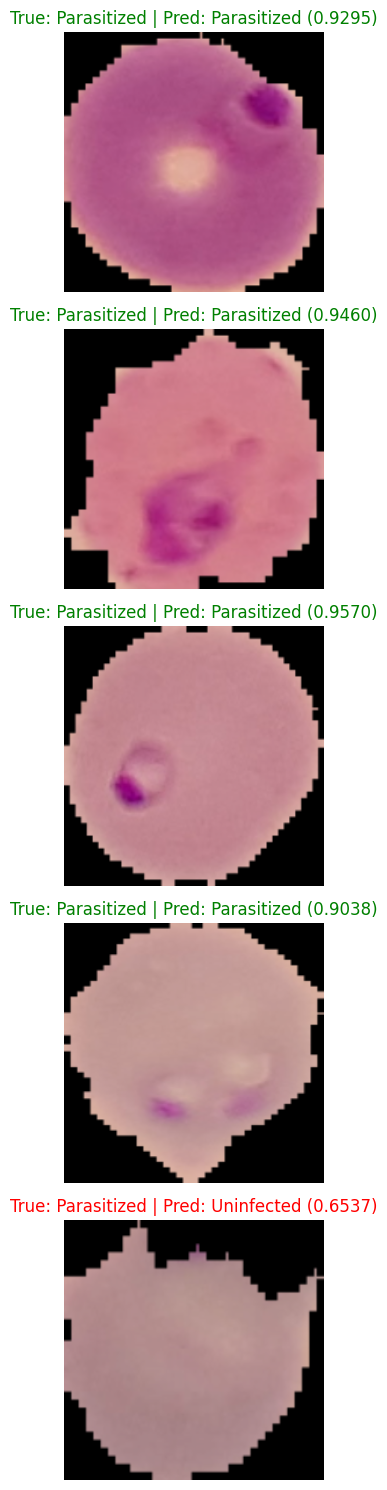


Model saved to ./models/malaria_rag_cot_ppo_model.pth

Generating explanations for test examples...

Example 1:


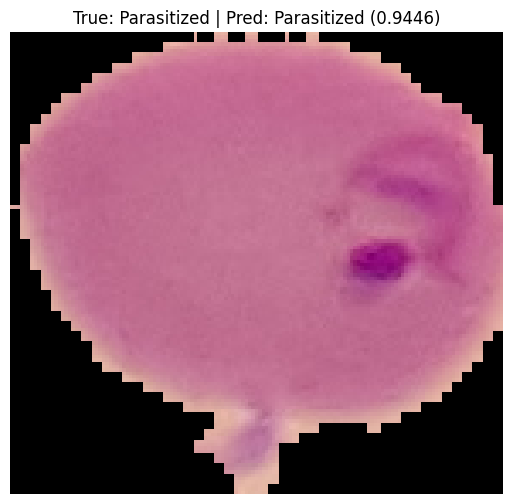

Step 1: Region-level focus revealed potential parasitic inclusions.
Step 2: The cell boundary was analyzed to assess morphological regularity.
Step 3: The overall cell appearance was benchmarked against uninfected examples.
Conclusion: The cell is **likely parasitized** with a confidence of 94.5%.
Key infection traits detected include:
- Disrupted membrane boundary
- Chromatin dot visibility
- Parasite-like inclusions within the cytoplasm

Reference Similar Cases:
- Case #1: Parasitized (similarity: -3.6%)
- Case #2: Uninfected (similarity: -14.0%)
- Case #3: Parasitized (similarity: -16.0%)


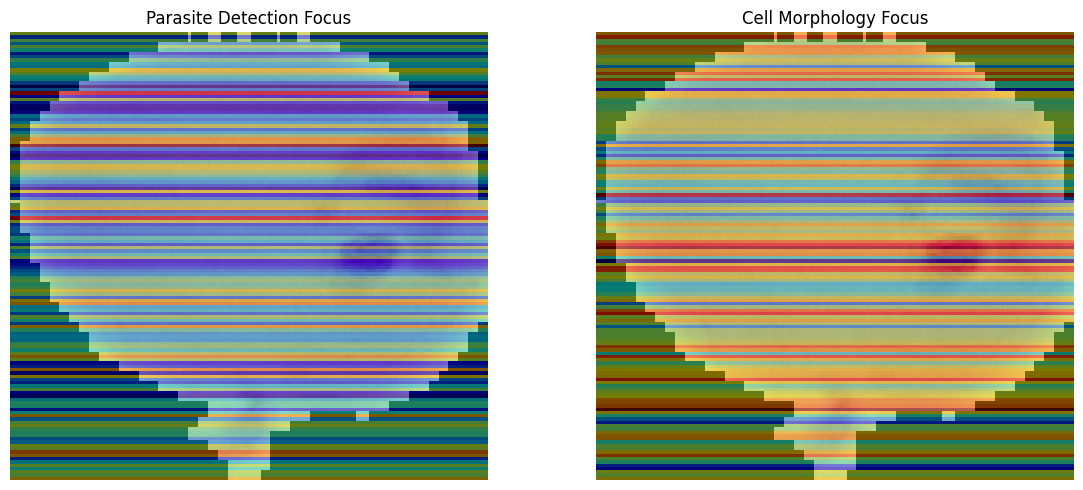


Example 2:


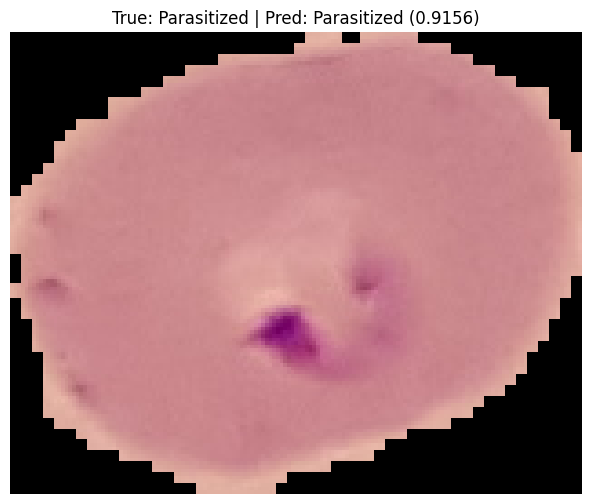

Step 1: The cell boundary was analyzed to assess morphological regularity.
Step 2: The overall cell appearance was benchmarked against uninfected examples.
Step 3: Structural anomalies were cross-verified with known parasitized patterns.
Conclusion: The cell is **likely parasitized** with a confidence of 91.6%.
Key infection traits detected include:
- Disrupted membrane boundary
- Chromatin dot visibility
- Parasite-like inclusions within the cytoplasm

Reference Similar Cases:
- Case #1: Parasitized (similarity: -28.8%)
- Case #2: Uninfected (similarity: -44.9%)
- Case #3: Uninfected (similarity: -51.3%)


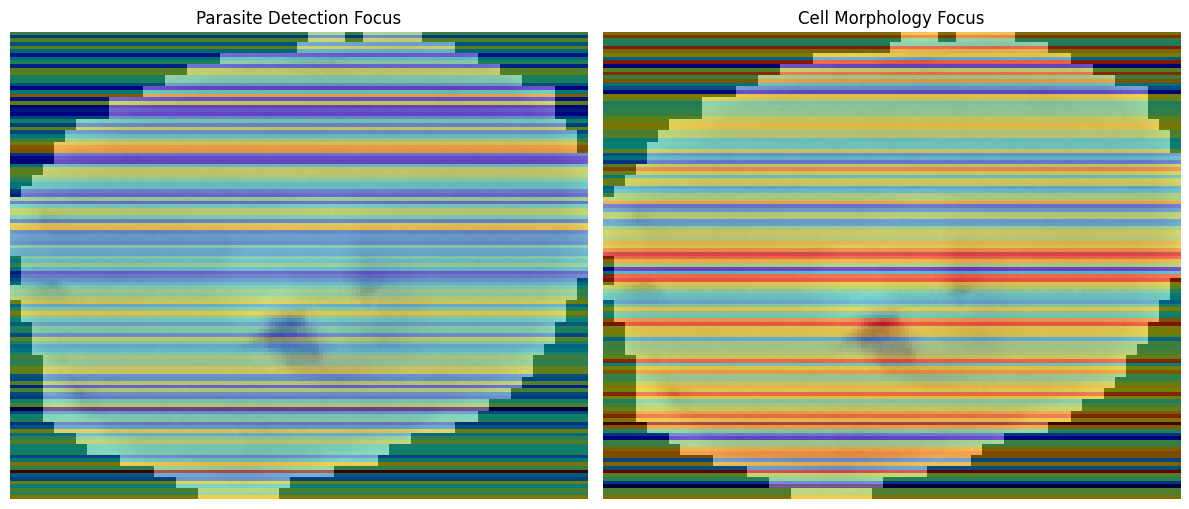


Example 3:


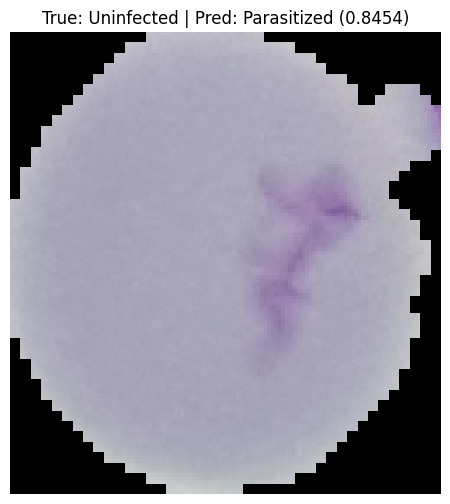

Step 1: The cell boundary was analyzed to assess morphological regularity.
Step 2: The cell boundary was analyzed to assess morphological regularity.
Step 3: The cell boundary was analyzed to assess morphological regularity.
Conclusion: The cell is **likely parasitized** with a confidence of 84.5%.
Key infection traits detected include:
- Disrupted membrane boundary
- Chromatin dot visibility
- Parasite-like inclusions within the cytoplasm

Reference Similar Cases:
- Case #1: Parasitized (similarity: 8.3%)
- Case #2: Parasitized (similarity: -13.0%)
- Case #3: Uninfected (similarity: -15.1%)


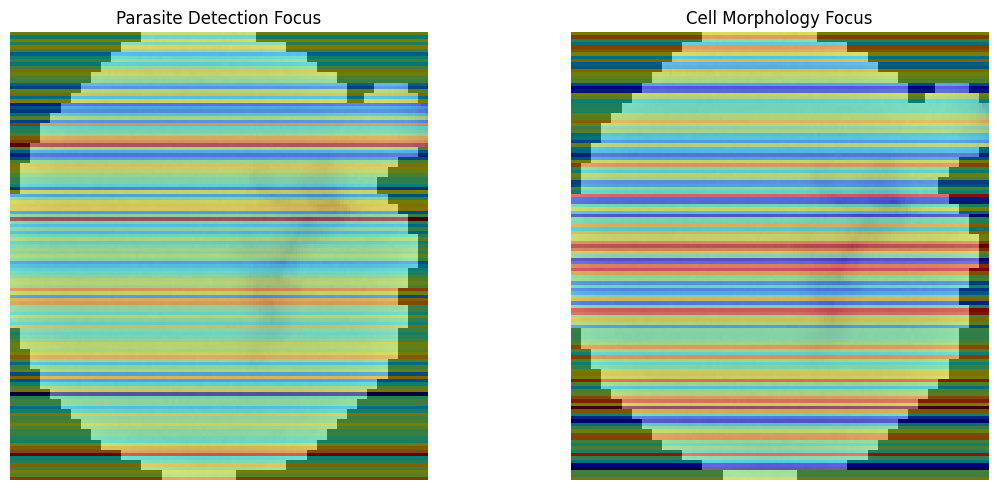


Final Results:
Accuracy: 0.8800

Confusion Matrix:
[[1628  427]
 [  69 2009]]

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.96      0.79      0.87      2055
 Parasitized       0.82      0.97      0.89      2078

    accuracy                           0.88      4133
   macro avg       0.89      0.88      0.88      4133
weighted avg       0.89      0.88      0.88      4133



In [7]:
def train_rag_cot_ppo_model(data_dir, output_dir='./models', base_model_name='deit_small_patch16_224'):
    """Main function to train and evaluate the full system."""
    print("Initializing Malaria Detection System with RAG + CoT + RL-PPO...")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load and prepare data
    print("\nPreparing dataset...")
    df = create_dataframe(data_dir)
    train_df, val_df, test_df = train_val_test_split(df)
    
    # Get transformations
    train_transforms, val_transforms = get_transforms()
    
    # Create datasets
    train_dataset = MalariaDataset(train_df, transform=train_transforms)
    val_dataset = MalariaDataset(val_df, transform=val_transforms)
    test_dataset = MalariaDataset(test_df, transform=val_transforms, return_path=True)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # 2. Initialize RAG system
    print("\nInitializing Retrieval-Augmented Generation (RAG) system...")
    embedder = MalariaImageEmbedder(model_name='resnet50')
    knowledge_base = MalariaKnowledgeBase(embedder)
    knowledge_base.add_images(train_df.sample(100))  # Use subset for testing
    
    # 3. Initialize CoT model with PPO capability
    print("\nInitializing Chain-of-Thought model...")
    model = CoTMalariaClassifier(base_model_name=base_model_name, num_reasoning_steps=3)
    model = model.to(device)
    
    # 4. Initialize optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    # 5. Initialize the complete system
    system = MalariaExplainableSystem(model, knowledge_base, device=device)
    
    # 6. Train with standard cross-entropy first
    print("\nPre-training with cross-entropy loss...")
    criterion = nn.CrossEntropyLoss()
    
    # Number of epochs for standard training
    num_ce_epochs = 7
    
    # Train with cross-entropy
    for epoch in range(num_ce_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_ce_epochs}")
        
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            logits, _, _ = model(images)
            loss = criterion(logits, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_loss += loss.item()
            progress_bar.set_postfix({
                'Loss': train_loss / (progress_bar.n + 1),
                'Acc': 100. * correct / total
            })
        
        # Validate
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                logits, _, _ = model(images)
                loss = criterion(logits, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100. * val_correct / val_total
        print(f"Epoch {epoch+1}/{num_ce_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {100. * correct / total:.2f}%, Val Acc: {val_accuracy:.2f}%")
    
    # 7. Fine-tune with PPO
    print("\nFine-tuning with PPO...")
    train_stats = system.train_with_ppo(
        dataloader=train_loader,
        optimizer=optimizer,
        epochs=5,
        ppo_updates_per_epoch=10,
        buffer_size=1024
    )
    
    # 8. Evaluate the final model
    print("\nEvaluating the final model...")
    eval_results = system.evaluate(test_loader, n_samples_to_visualize=5)
    
    # 9. Save the model
    model_path = os.path.join(output_dir, 'malaria_rag_cot_ppo_model.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'eval_results': eval_results,
    }, model_path)
    
    print(f"\nModel saved to {model_path}")
    
    # 10. Visualize full explanations for a few test examples
    print("\nGenerating explanations for test examples...")
    # Get a few test samples with paths
    test_samples = []
    for images, labels, paths in test_loader:
        for i in range(len(images)):
            test_samples.append((images[i], labels[i], paths[i]))
        if len(test_samples) >= 3:
            break
    
    # Generate and display explanations
    for i, (image, label, path) in enumerate(test_samples[:3]):
        print(f"\nExample {i+1}:")
        result = system.inference_with_explanation(path)
        
        # Display image
        img = Image.open(path).convert('RGB')
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.title(f"True: {'Parasitized' if label == 1 else 'Uninfected'} | "
                 f"Pred: {'Parasitized' if result['prediction'] == 1 else 'Uninfected'} "
                 f"({result['confidence']:.4f})")
        plt.axis('off')
        plt.show()
        
        # Print explanation
        print(result['explanation'])
        
        # Show attention maps
        if 'attention_maps' in result:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Parasite attention
            parasite_attn = result['attention_maps']['parasite_attention'].squeeze().cpu().numpy()
            parasite_attn = cv2.resize(parasite_attn, (img.width, img.height))
            axes[0].imshow(img)
            axes[0].imshow(parasite_attn, alpha=0.5, cmap='jet')
            axes[0].set_title('Parasite Detection Focus')
            axes[0].axis('off')
            
            # Cell attention
            cell_attn = result['attention_maps']['cell_attention'].squeeze().cpu().numpy()
            cell_attn = cv2.resize(cell_attn, (img.width, img.height))
            axes[1].imshow(img)
            axes[1].imshow(cell_attn, alpha=0.5, cmap='jet')
            axes[1].set_title('Cell Morphology Focus')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
    
    return system, eval_results

if __name__ == '__main__':
    DATA_DIR = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'
    system, results = train_rag_cot_ppo_model(
        data_dir=DATA_DIR,
        output_dir='./models',
        base_model_name='deit_small_patch16_224'
    )
    
    # Print final results
    print("\nFinal Results:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print("\nConfusion Matrix:")
    print(results['confusion_matrix'])
    print("\nClassification Report:")
    print(results['classification_report'])

----------------------------